# Financial Econometrics: Homework 2
#### Kryštof Veřtát, Tomáš Svoboda

## Problem 1

### Part 1

In [1]:
library(fGarch)
library(repr)
library(forecast)
library(aTSA)
library(rugarch)
library(tseries)
library(fDMA)
library(quantmod)

Warning message:
"package 'fGarch' was built under R version 4.3.3"
NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")

Warning message:
"package 'forecast' was built under R version 4.3.3"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'aTSA'


The following object is masked from 'package:forecast':

    forecast


The following object is masked from 'package:graphics':

    identify


Warning message:
"package 'rugarch' was built under R version 4.3.3"
Loading required package: parallel


Attaching package: 'rugarch'


The following object is masked from 'package:stats':

    sigma


Warning message:
"package 'tseries' was built under R version 4.3.3"

Attaching package: 'tseries'


The following objects are masked from 'package:aTSA':

    adf.test, kp

In [2]:
symbols <- read.csv("symbols2.csv")

head(symbols)

set.seed(62635431)

rows <- sample(x = 1:377, size = 100, replace = F)

symbols_download <- as.character(symbols[rows,2])

,X,Symbol,Name,Sector
,<int>,<chr>,<chr>,<chr>
1,1,MMM,3M Co.,Industrials
2,2,ACE,ACE Limited,Financials
3,3,ABT,Abbott Laboratories,Health Care
4,4,ANF,Abercrombie & Fitch Company A,Consumer Discretionary
5,5,ACN,Accenture,Information Technology
6,6,ADBE,Adobe Systems Inc,Information Technology


In [3]:
# Download data for selected period
data <- lapply(symbols_download, function(y) {
  tryCatch({
    getSymbols(y, auto.assign = FALSE, src = "yahoo", from = "2020-01-01", to = "2022-10-01")
  }, error = function(e) {
    message(paste("Error downloading data for", y, "-", e$message))
    return(NULL)
  })
})

Error downloading data for RRD - Unable to import "RRD".
HTTP error 404.

Error downloading data for BMS - Unable to import "BMS".
attempt to set an attribute on NULL

Error downloading data for BHI - Unable to import "BHI".
attempt to set an attribute on NULL

Error downloading data for FISV - Unable to import "FISV".
HTTP error 400.

Error downloading data for DISCA - Unable to import "DISCA".
HTTP error 404.

Error downloading data for BBBY - Unable to import "BBBY".
HTTP error 404.

Error downloading data for PKI - Unable to import "PKI".
HTTP error 404.

Error downloading data for LLL - Unable to import "LLL".
HTTP error 404.

Error downloading data for LSI - Unable to import "LSI".
HTTP error 404.



In [4]:
# Keep only closing prices and remove stocks that are not in quantmod package
data <- lapply(data, function(y){
  y <- y[,4]
})

data <- data[sapply(data, function(x) !is.null(x))]

# Calculate returns from the closing prices
returns <- lapply(data, function(y){
  na.omit(diff(log(y)))
})

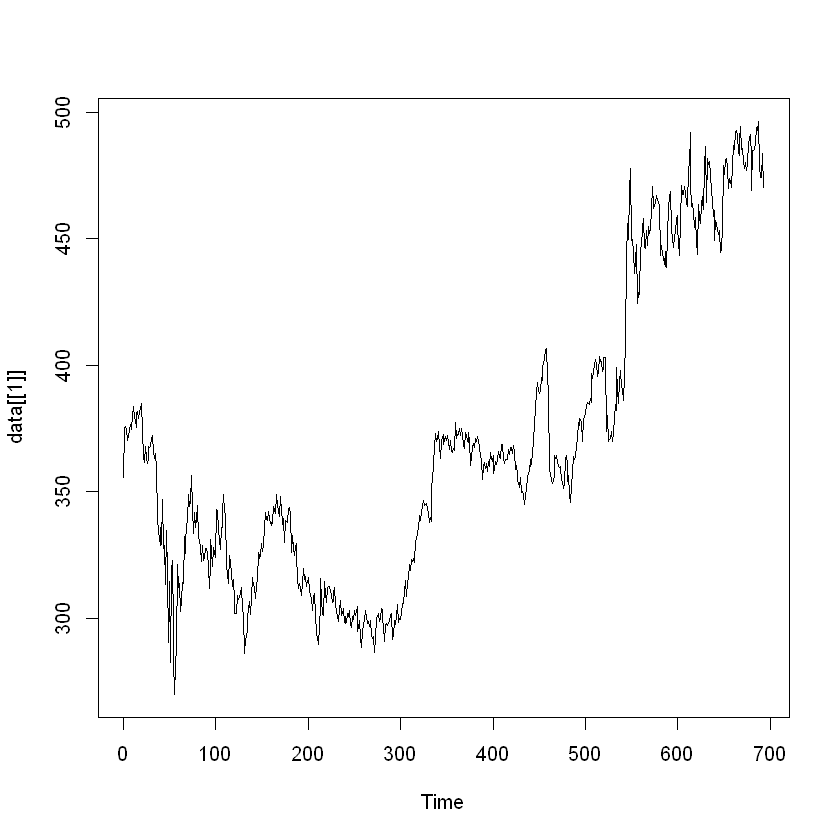

In [5]:
plot.ts(data[[1]])

### Part 2

In [6]:
# Specify GARCH(1,1) model and estimate it for each stock
spec <- ugarchspec(mean.model = list(armaOrder=c(0, 0)), variance.model = list(garchOrder = c(1, 1)))
models <- lapply(returns, function(y){
                 ugarchfit(spec, y)})


### Part 3

In [7]:
# Get alpha, beta and alpha+beta coefficients from the results of the model
alpha_values <- lapply(models, function(model) coef(model)[["alpha1"]])

beta_values <- lapply(models, function(model) coef(model)[["beta1"]])

alpha_beta <- unlist(alpha_values) + unlist(beta_values)

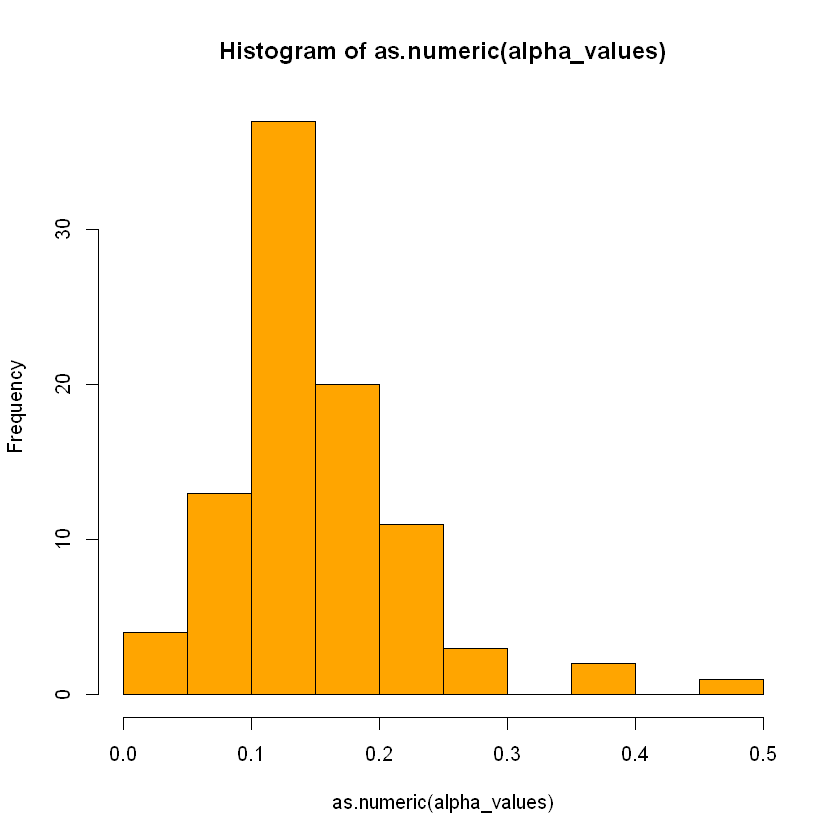

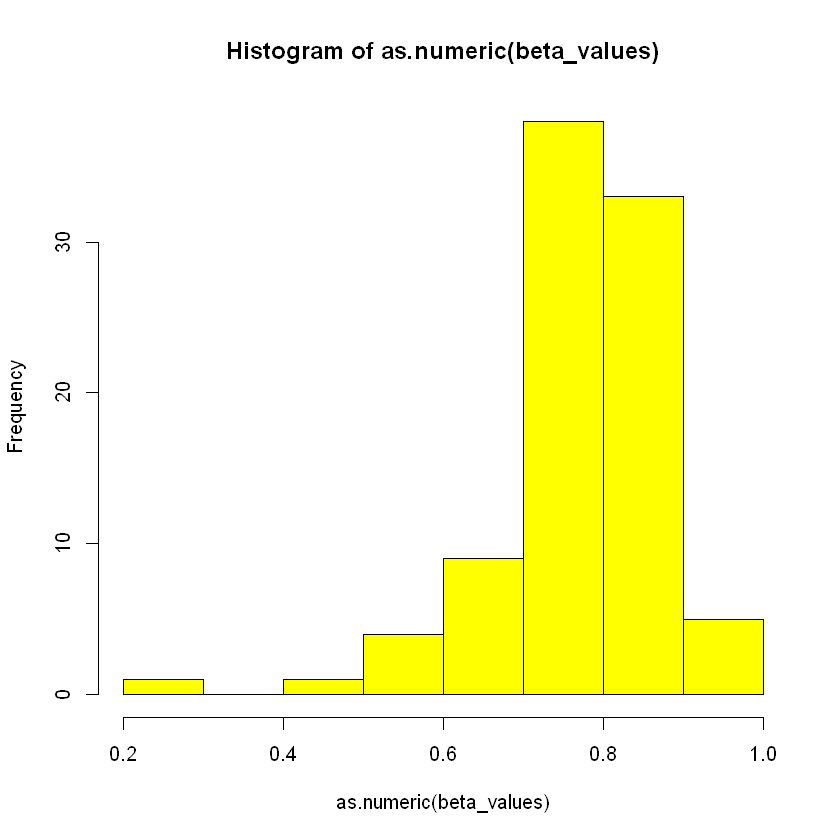

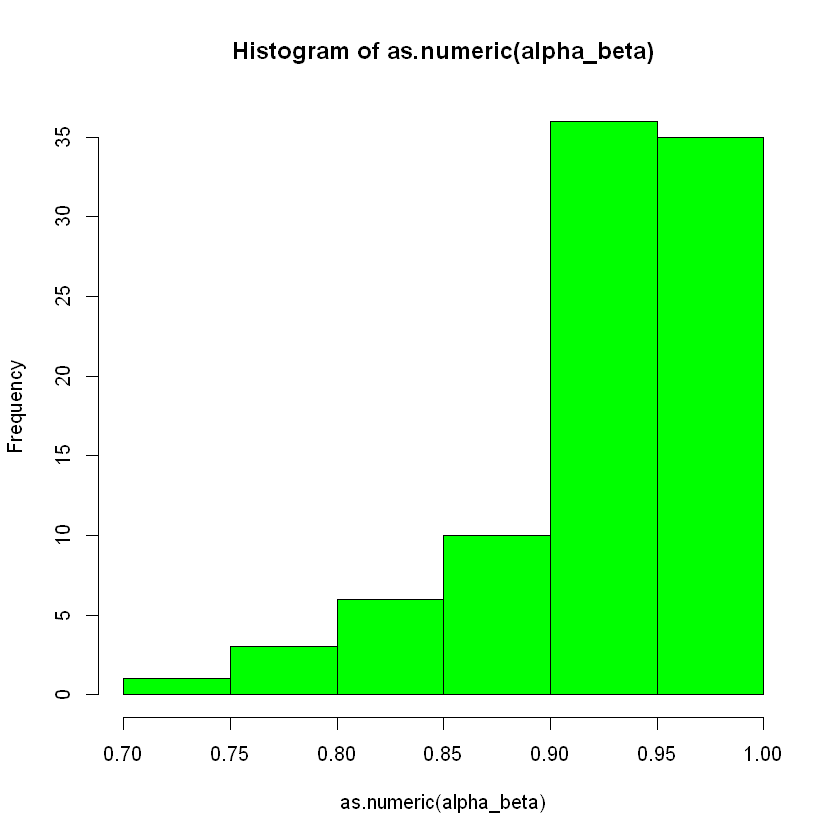

In [8]:
# Plot histograms with the coefficients
hist(as.numeric(alpha_values), col = "orange")

hist(as.numeric(beta_values), col = "yellow")

hist(as.numeric(alpha_beta), col = "green")

Histograms show that alpha coefficients have lower values, mostly below 0.3, while beta has relatively high values above 0.6. Sum of alpha and beta is very close to 1, but slightly lower, so it fulfills necessary condition that $\alpha + \beta < 1$. Value of alpha being lower than value of beta indicates that shocks to volatility caused by increased conditionall variance are more persistant compared to those caused by returns.

### Part 4

In [9]:
# Find minimum and maximum values for each coefficient
min(unlist(alpha_values))
max(unlist(alpha_values))

min(unlist(beta_values))
max(unlist(beta_values))

min(unlist(alpha_beta))
max(unlist(alpha_beta))

[1] 9.567226e-05

[1] 0.4974981

[1] 0.2695484

[1] 0.9982769

[1] 0.7405824

[1] 0.999

### Part 5

In [10]:
# Get median and quantiles for each day
medians <- vector()
quantiles_95 <- vector()
quantiles_05 <- vector()

for (i in 1:692){
  returns_daily <- vector()
  returns_daily <- lapply(models, function(model)model@fit$sigma[i])
  medians[i] <- median(unlist(returns_daily))
  quantiles_05[i] <- quantile(unlist(returns_daily),probs = 0.05)
  quantiles_95[i] <- quantile(unlist(returns_daily),probs = 0.95)
}

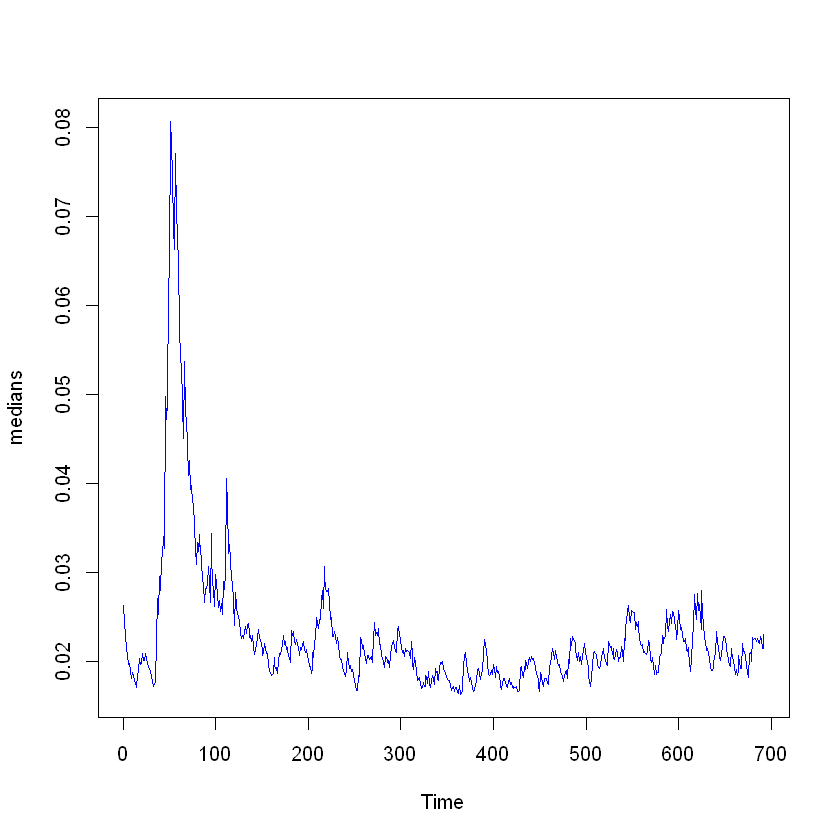

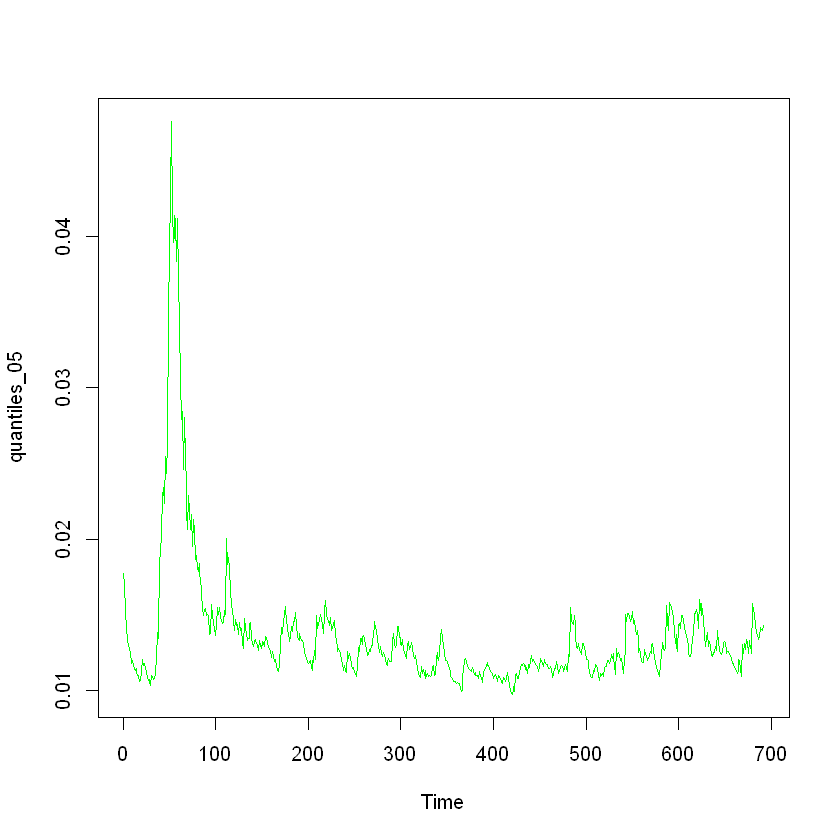

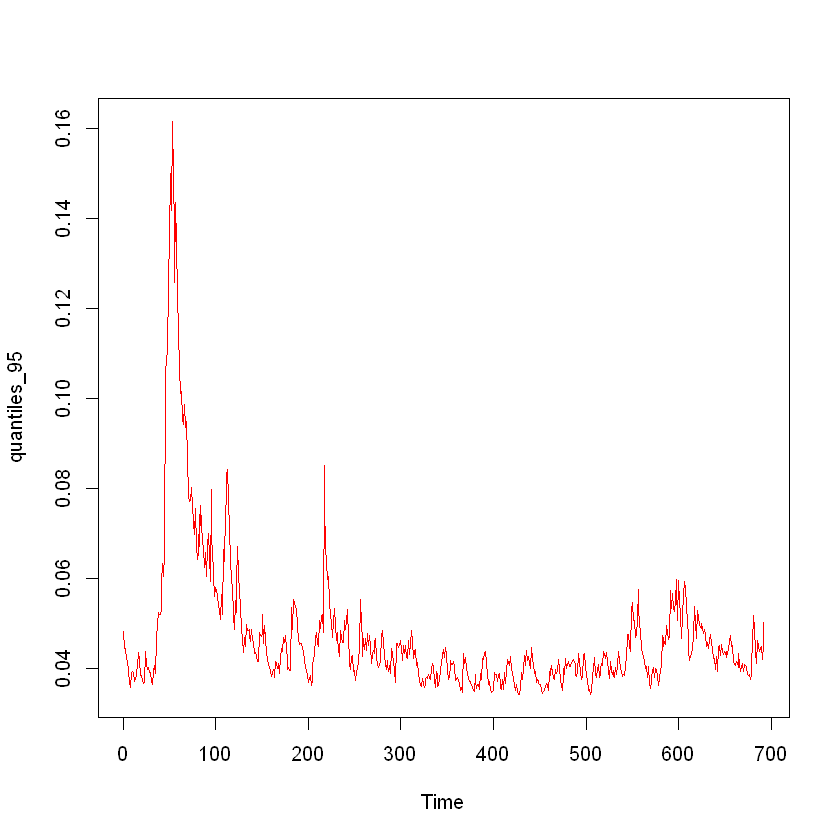

In [11]:
# Plot time series of median, 0.05 quantile and 0.95 quantile
plot.ts(medians, col = "blue")
plot.ts(quantiles_05, col = "green")
plot.ts(quantiles_95, col = "red")

Median, 95 % and 5 % quantile of the returns have approximately the same figure with different magnituted. We can see that all three have the highest volatility during the first 100 days, where it seems to be the most persitant. Then it lowering and there are only smaller spikes in volatility. Especially for 95 % quantile the spikes are relatively higher. 

## Problem 2

We begin this section with calculating daily mean logarithmic returns

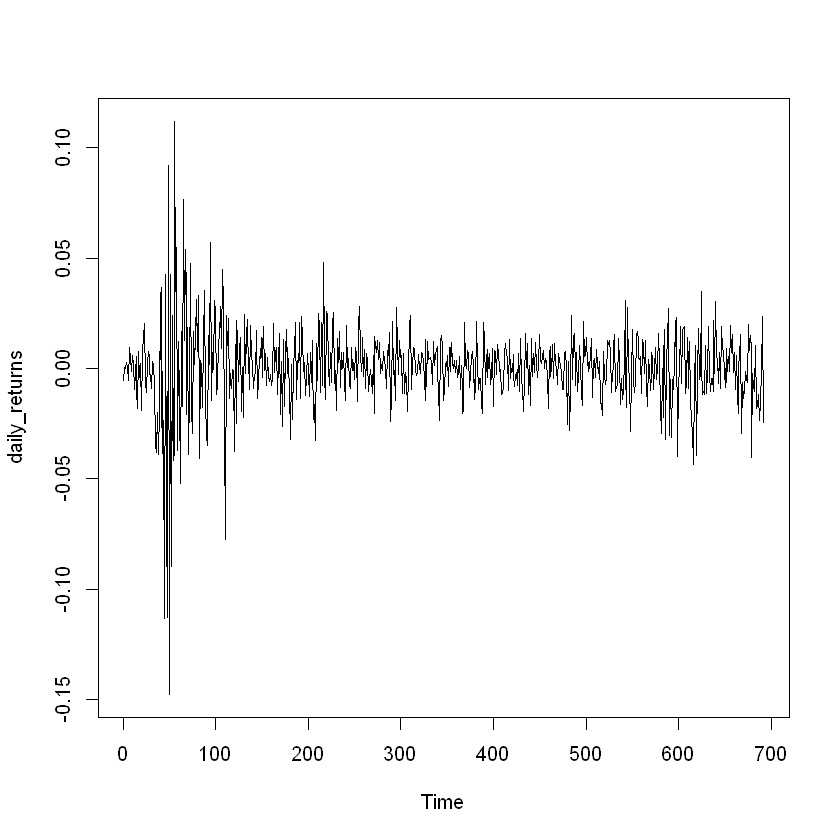

In [12]:
t <- lengths(returns)[1]

daily_returns <- sapply(1:t, function(y){
    mean(sapply(returns, '[[', y))
})

plot.ts(daily_returns)


Results of the mean log-returns suggest that the volatility of daily returns substantially varies across time in average. That could cause some heterogeneity issues later if not treated correctly. This irregularity is probably caused by the Covid-19 pandemic.

To be able to model time series at all, we neeed to ensure the stationarity.

In [13]:
# Augmented Dickey-Fuller test for stationarity
adf.test(daily_returns)

Warning message in adf.test(daily_returns):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  daily_returns
Dickey-Fuller = -7.3568, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


Since we succesfully rejected the "H0 = non-stationary" hypothesis for a standard 95% significance level, the time series proces is stationary. We are thus able to proceed to autocorrelation modelling of daily returns without a need for differencing. To see the correlations and estimate the orders, ACF and PACF functions are constructed.

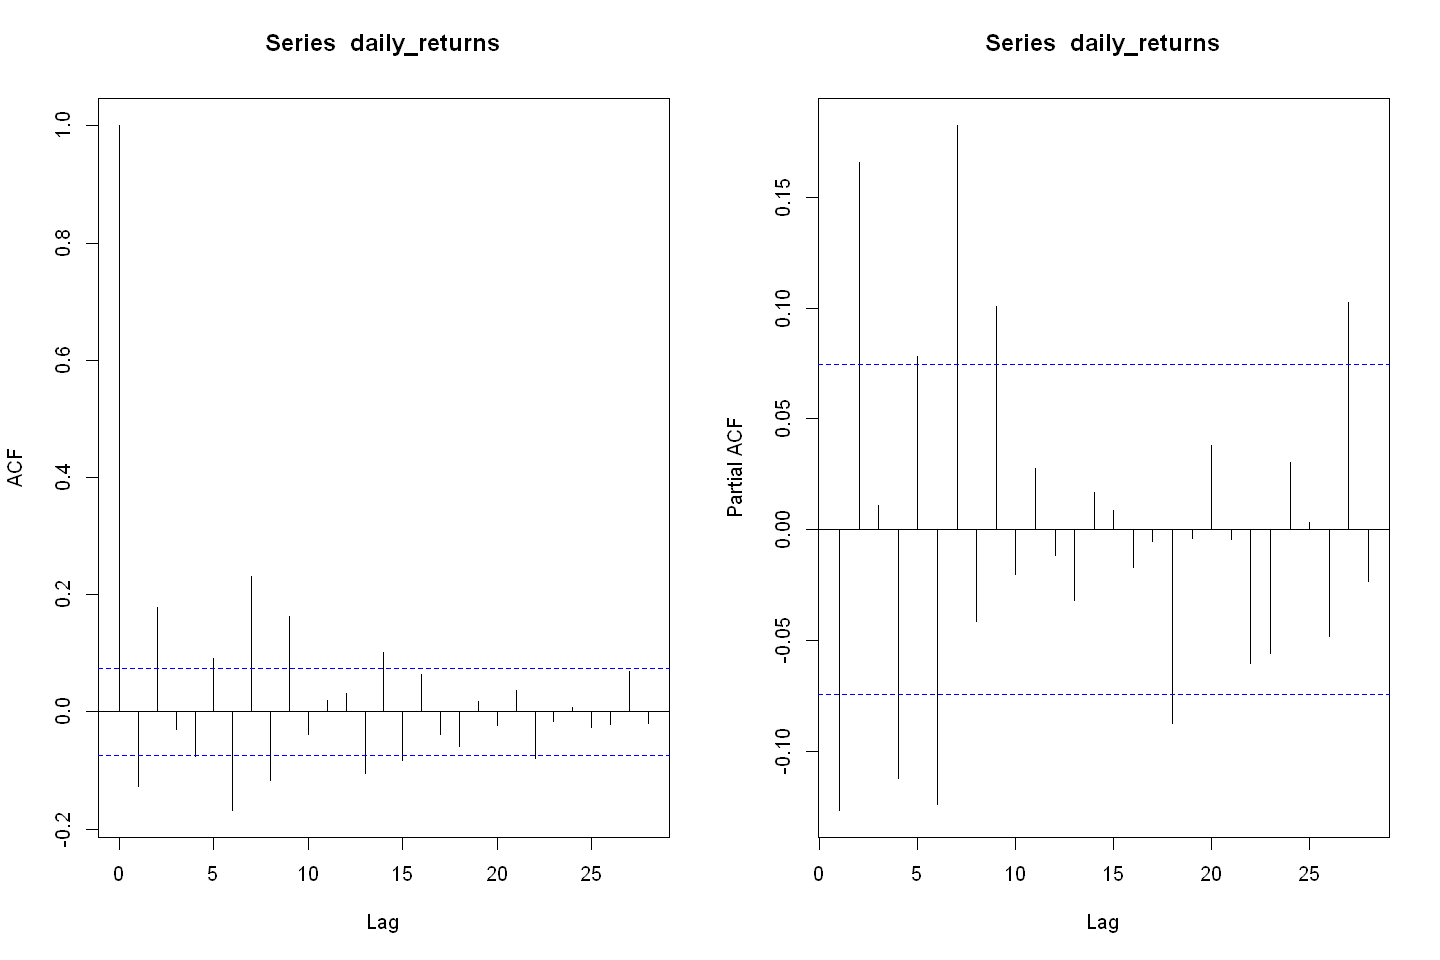

In [14]:
options(repr.plot.width=12, repr.plot.height=8)
par(mfrow = c(1, 2))

# Autocorrelation function
acf(daily_returns)
# Partial autocorrelation function
pacf(daily_returns)

The PACF functions indicates that there is a direct influence of lagged values, especially for first 7 or 8 lags, on a current value in our time series. Also the ACF function modelling, in addition, the indirect effect of lagged values reports correlations out of the boundary for at least the first 7 or 8 lags.

The implication is that there is serial correlation in our residuals causing past values affect the current one. Since this is problematic for standard econometric modelling, we want to get rid of it while extracting as much information as possible.

To remove the dependencies, we estimated ARMA models with several different orders. We evaluated various combinations of order hyperparameters according to the ACF and PACF functions and selected only the best combinations for a presentation.    

#### a) Automatic ARIMA

Series: daily_returns 
ARIMA(0,0,2) with zero mean 

Coefficients:
          ma1     ma2
      -0.0948  0.1939
s.e.   0.0372  0.0379

sigma^2 = 0.0003384:  log likelihood = 1783.99
AIC=-3561.99   AICc=-3561.95   BIC=-3548.37


	Box-Ljung test

data:  auto$residuals
X-squared = 3.2489, df = 4, p-value = 0.5171



	Box-Ljung test

data:  auto$residuals
X-squared = 40.522, df = 8, p-value = 2.561e-06



	Box-Ljung test

data:  auto$residuals
X-squared = 51.041, df = 12, p-value = 9.161e-07


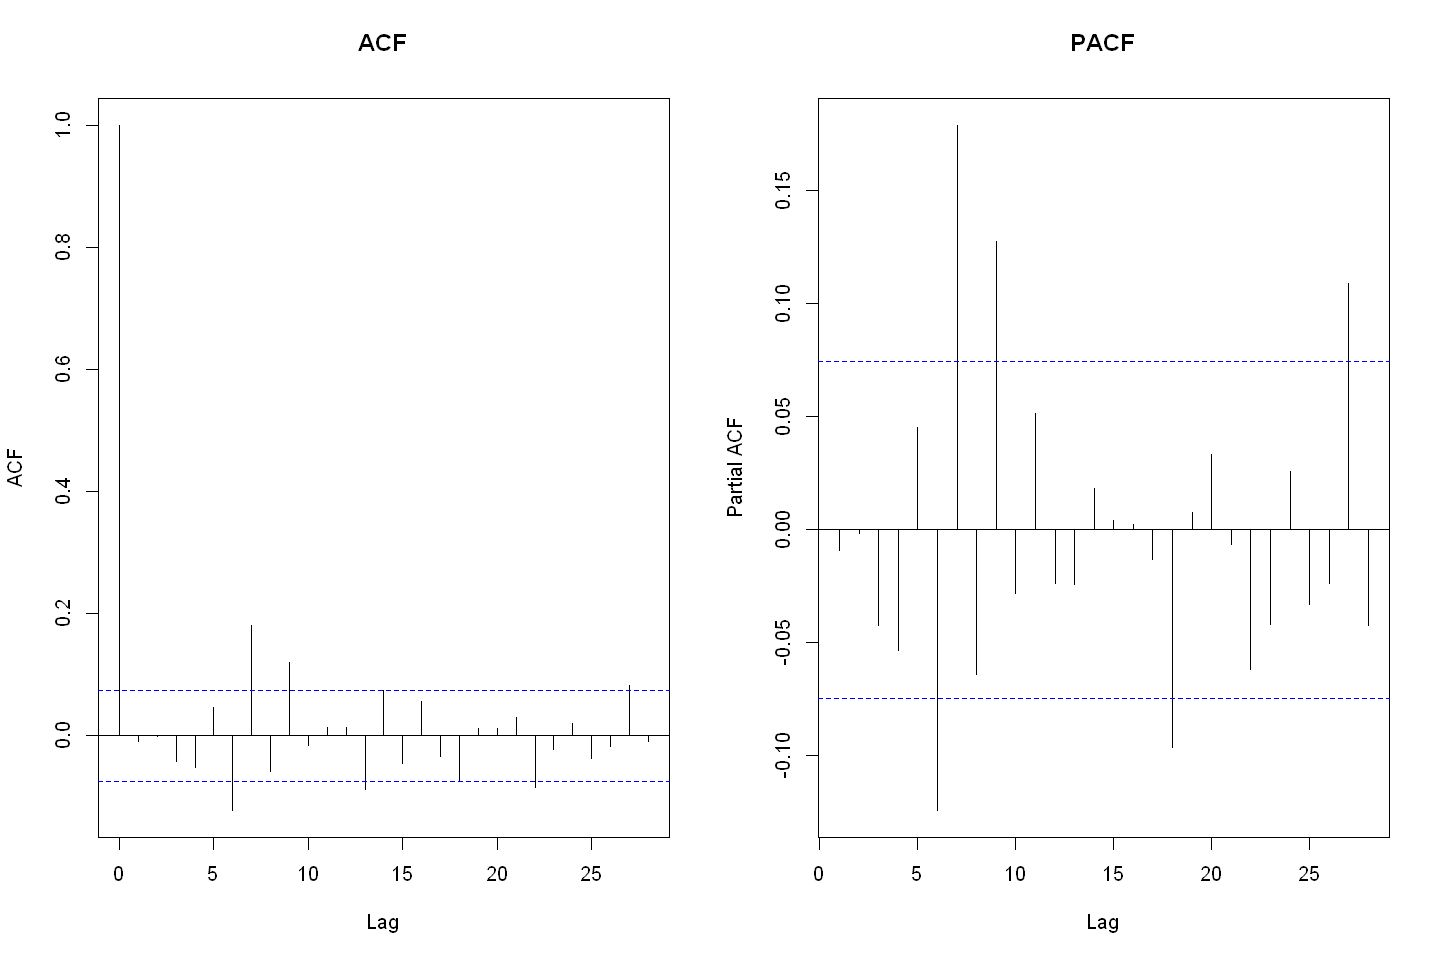

In [15]:
auto <- auto.arima(daily_returns, max.d = 0) # No need of differencing stationary series
auto

par(mfrow = c(1, 2))
acf(auto$residuals, main = "ACF")
pacf(auto$residuals, main = "PACF")

Box.test(auto$residuals, type = "Ljung-Box", lag = 4)
Box.test(auto$residuals, type = "Ljung-Box", lag = 8)
Box.test(auto$residuals, type = "Ljung-Box", lag = 12)

#### b) AR(7)

Series: daily_returns 
ARIMA(7,0,0) with non-zero mean 

Coefficients:
          ar1     ar2      ar3      ar4     ar5      ar6     ar7   mean
      -0.0646  0.1608  -0.0026  -0.0776  0.0343  -0.1072  0.1826  0e+00
s.e.   0.0374  0.0372   0.0378   0.0376  0.0377   0.0373  0.0374  8e-04

sigma^2 = 0.0003196:  log likelihood = 1806.63
AIC=-3595.26   AICc=-3594.99   BIC=-3554.4


	Box-Ljung test

data:  ar_7$residuals
X-squared = 0.85828, df = 4, p-value = 0.9305



	Box-Ljung test

data:  ar_7$residuals
X-squared = 1.7953, df = 8, p-value = 0.9867



	Box-Ljung test

data:  ar_7$residuals
X-squared = 9.9192, df = 12, p-value = 0.623


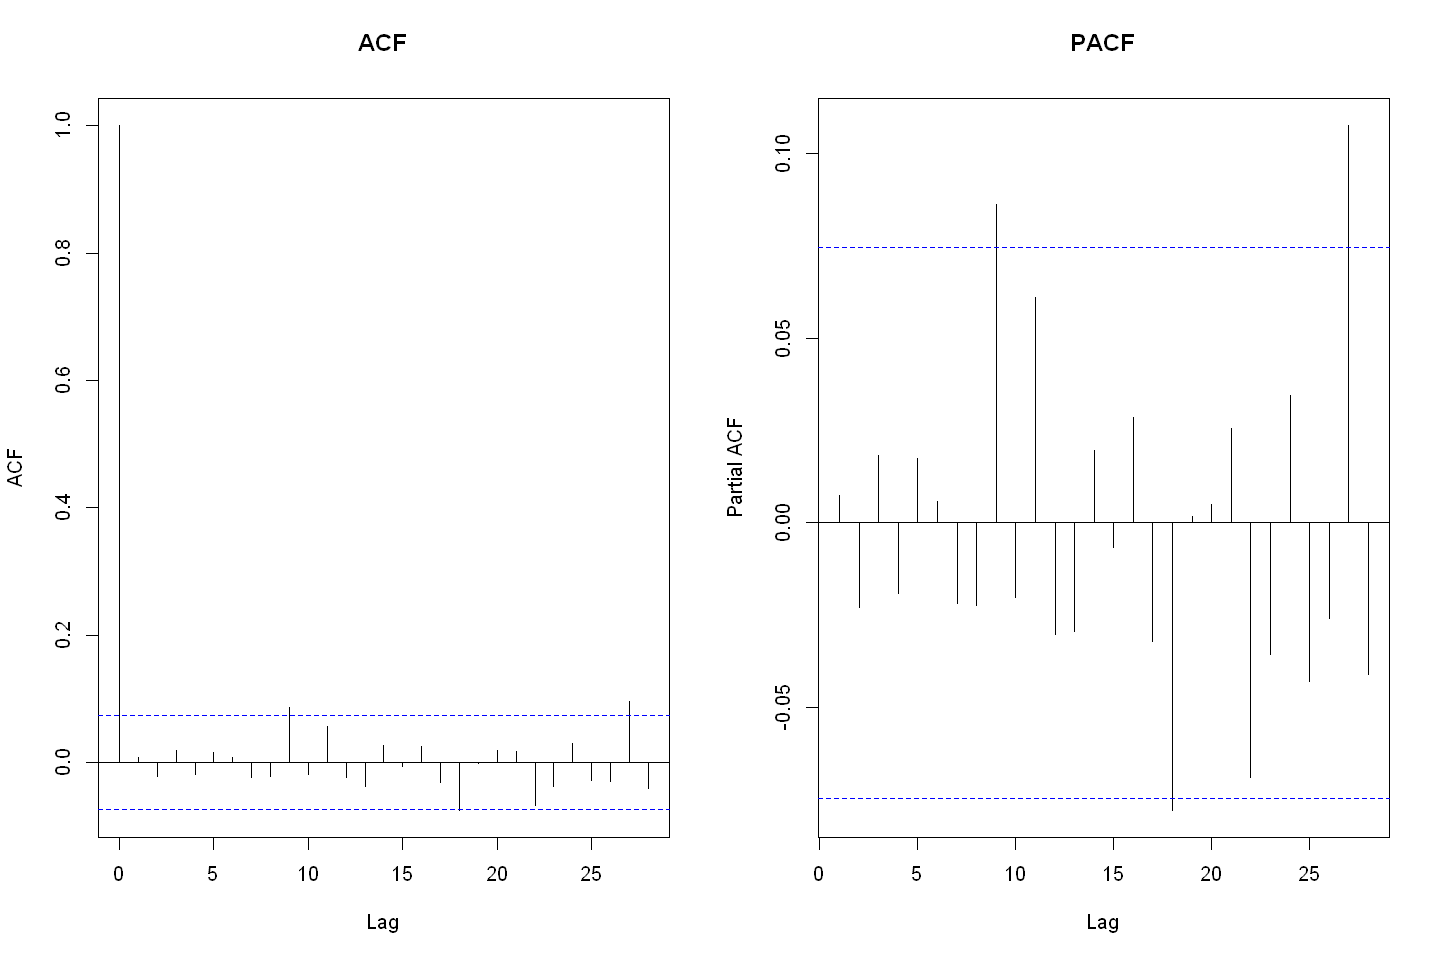

In [16]:
ar_7 <- Arima(daily_returns, order=c(7,0,0))
ar_7

par(mfrow = c(1, 2))
acf(ar_7$residuals, main = "ACF")
pacf(ar_7$residuals, main = "PACF")

Box.test(ar_7$residuals, type = "Ljung-Box", lag = 4)
Box.test(ar_7$residuals, type = "Ljung-Box", lag = 8)
Box.test(ar_7$residuals, type = "Ljung-Box", lag = 12)

#### c) MA(8)

Series: daily_returns 
ARIMA(0,0,8) with non-zero mean 

Coefficients:
          ma1     ma2     ma3      ma4     ma5      ma6     ma7      ma8   mean
      -0.0545  0.1273  0.0151  -0.0993  0.0821  -0.1298  0.1728  -0.0592  1e-04
s.e.   0.0381  0.0382  0.0376   0.0378  0.0386   0.0383  0.0375   0.0375  7e-04

sigma^2 = 0.0003244:  log likelihood = 1802.04
AIC=-3584.07   AICc=-3583.75   BIC=-3538.68


	Box-Ljung test

data:  ma_8$residuals
X-squared = 0.50681, df = 4, p-value = 0.9728



	Box-Ljung test

data:  ma_8$residuals
X-squared = 1.4801, df = 8, p-value = 0.993



	Box-Ljung test

data:  ma_8$residuals
X-squared = 13.164, df = 12, p-value = 0.3573


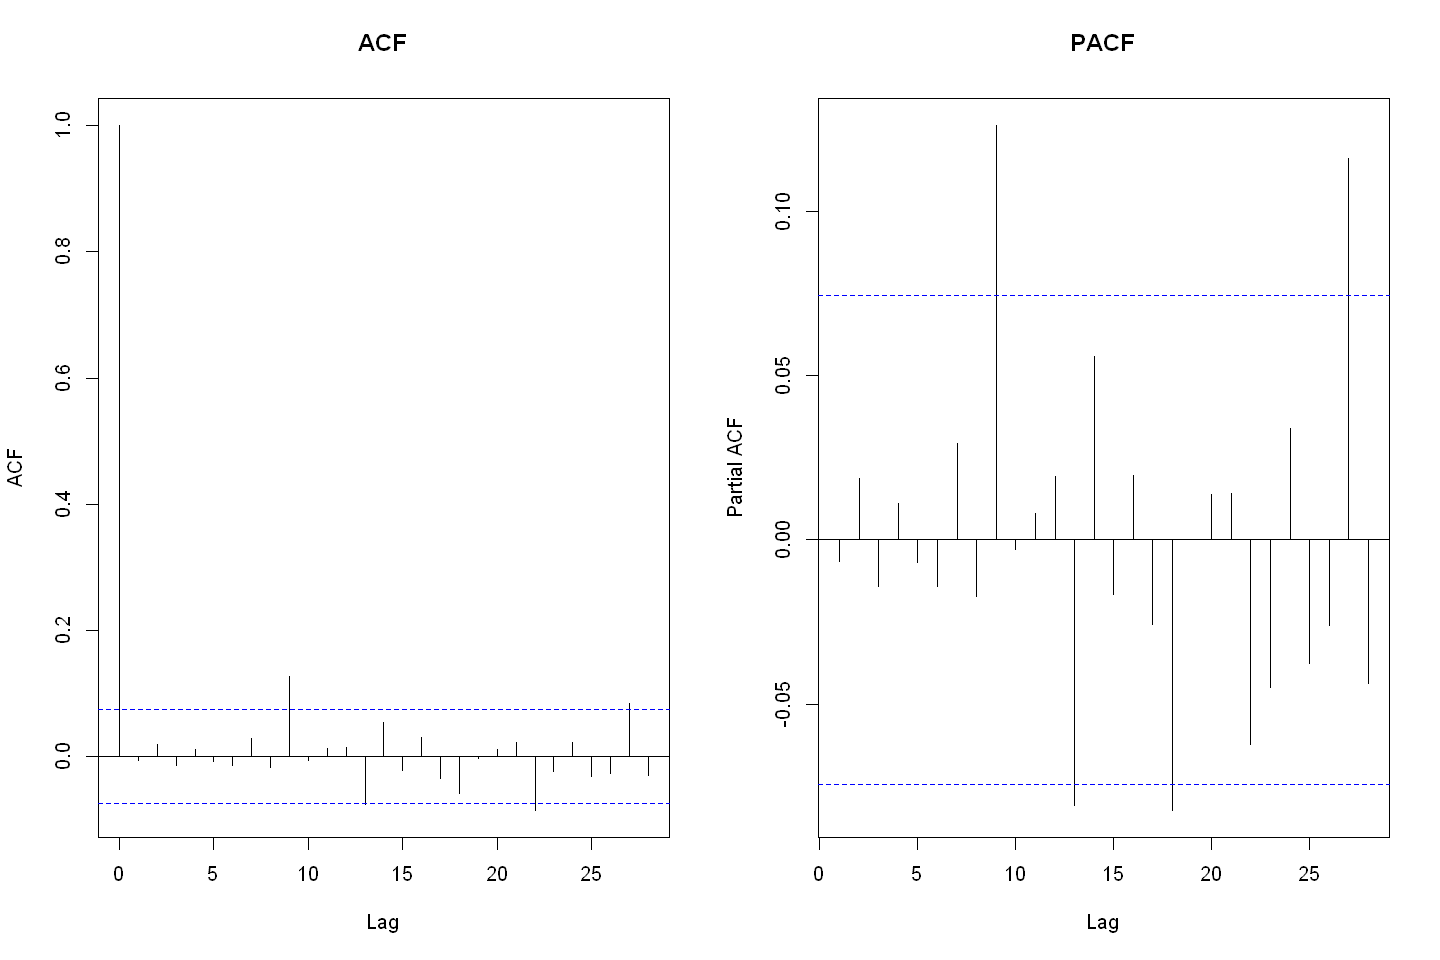

In [17]:
ma_8 <- Arima(daily_returns, order=c(0,0,8))
ma_8

par(mfrow = c(1, 2))
acf(ma_8$residuals, main = "ACF")
pacf(ma_8$residuals, main = "PACF")

Box.test(ma_8$residuals, type = "Ljung-Box", lag = 4)
Box.test(ma_8$residuals, type = "Ljung-Box", lag = 8)
Box.test(ma_8$residuals, type = "Ljung-Box", lag = 12)

#### d) ARMA(4,1)

Series: daily_returns 
ARIMA(4,0,1) with non-zero mean 

Coefficients:
          ar1     ar2     ar3      ar4     ma1   mean
      -0.8994  0.1051  0.1281  -0.1305  0.8438  0e+00
s.e.   0.0563  0.0512  0.0514   0.0407  0.0443  7e-04

sigma^2 = 0.0003211:  log likelihood = 1803.98
AIC=-3593.96   AICc=-3593.79   BIC=-3562.18


	Box-Ljung test

data:  arma_41$residuals
X-squared = 1.1475, df = 4, p-value = 0.8867



	Box-Ljung test

data:  arma_41$residuals
X-squared = 8.5932, df = 8, p-value = 0.3778



	Box-Ljung test

data:  arma_41$residuals
X-squared = 11.07, df = 12, p-value = 0.523


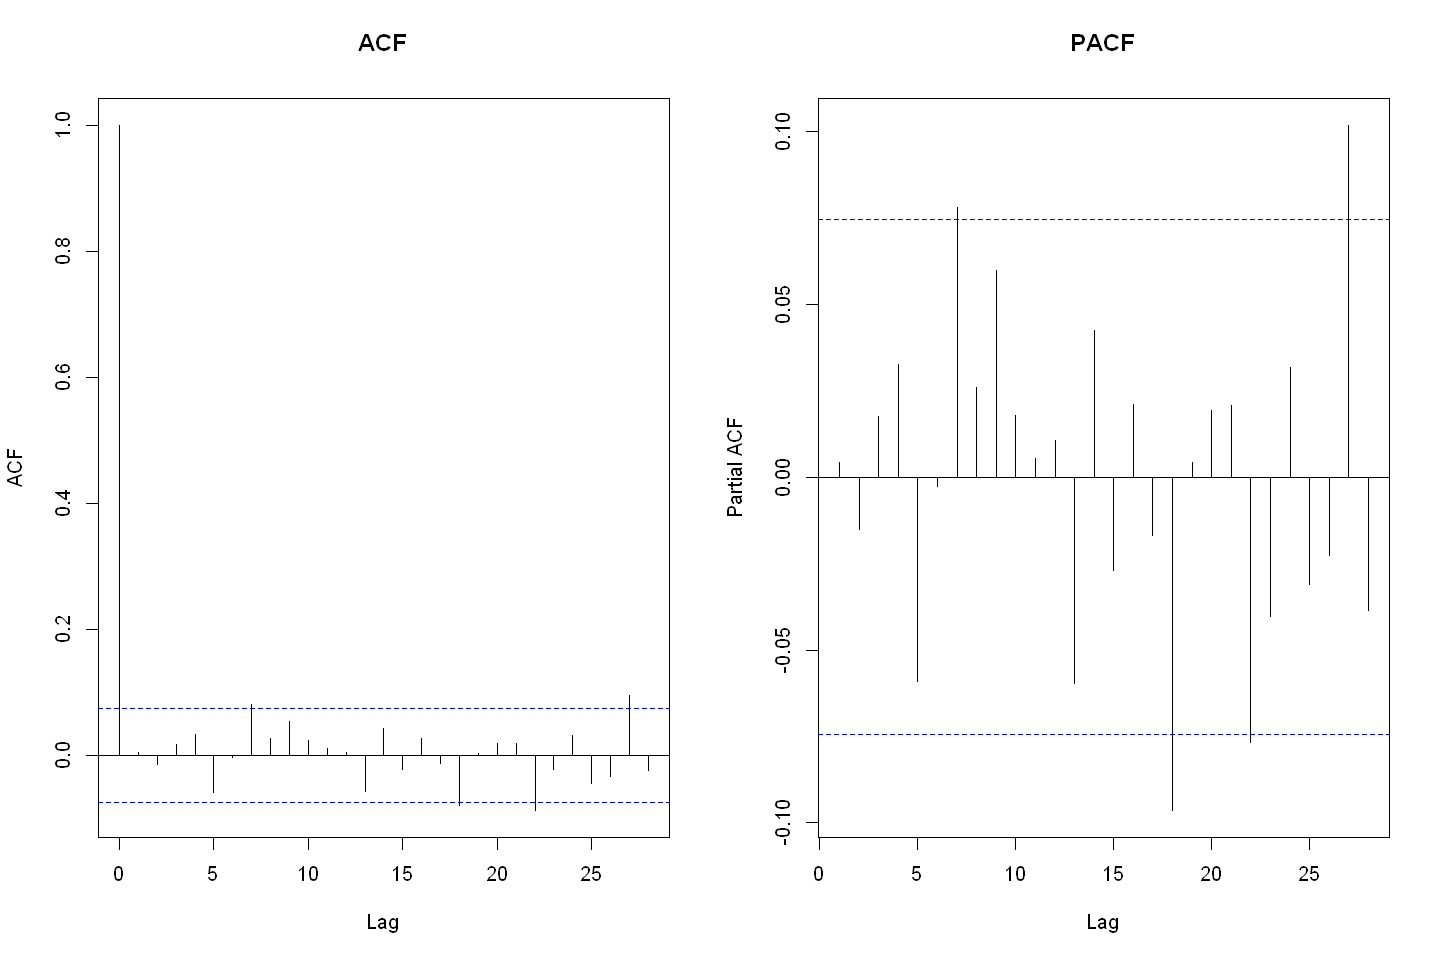

In [18]:
arma_41 <- Arima(daily_returns, order=c(4,0,1))
arma_41

par(mfrow = c(1, 2))
acf(arma_41$residuals, main = "ACF")
pacf(arma_41$residuals, main = "PACF")

Box.test(arma_41$residuals, type = "Ljung-Box", lag = 4)
Box.test(arma_41$residuals, type = "Ljung-Box", lag = 8)
Box.test(arma_41$residuals, type = "Ljung-Box", lag = 12)

#### e) ARMA(3,3)

Series: daily_returns 
ARIMA(3,0,3) with non-zero mean 

Coefficients:
          ar1      ar2     ar3     ma1     ma2      ma3   mean
      -1.4450  -0.4425  0.1922  1.4008  0.5175  -0.0236  0e+00
s.e.   0.2665   0.4587  0.2345  0.2700  0.4331   0.2027  7e-04

sigma^2 = 0.0003192:  log likelihood = 1806.58
AIC=-3597.15   AICc=-3596.94   BIC=-3560.83


	Box-Ljung test

data:  arma_33$residuals
X-squared = 0.37093, df = 4, p-value = 0.9848



	Box-Ljung test

data:  arma_33$residuals
X-squared = 6.4008, df = 8, p-value = 0.6024



	Box-Ljung test

data:  arma_33$residuals
X-squared = 9.3635, df = 12, p-value = 0.6716


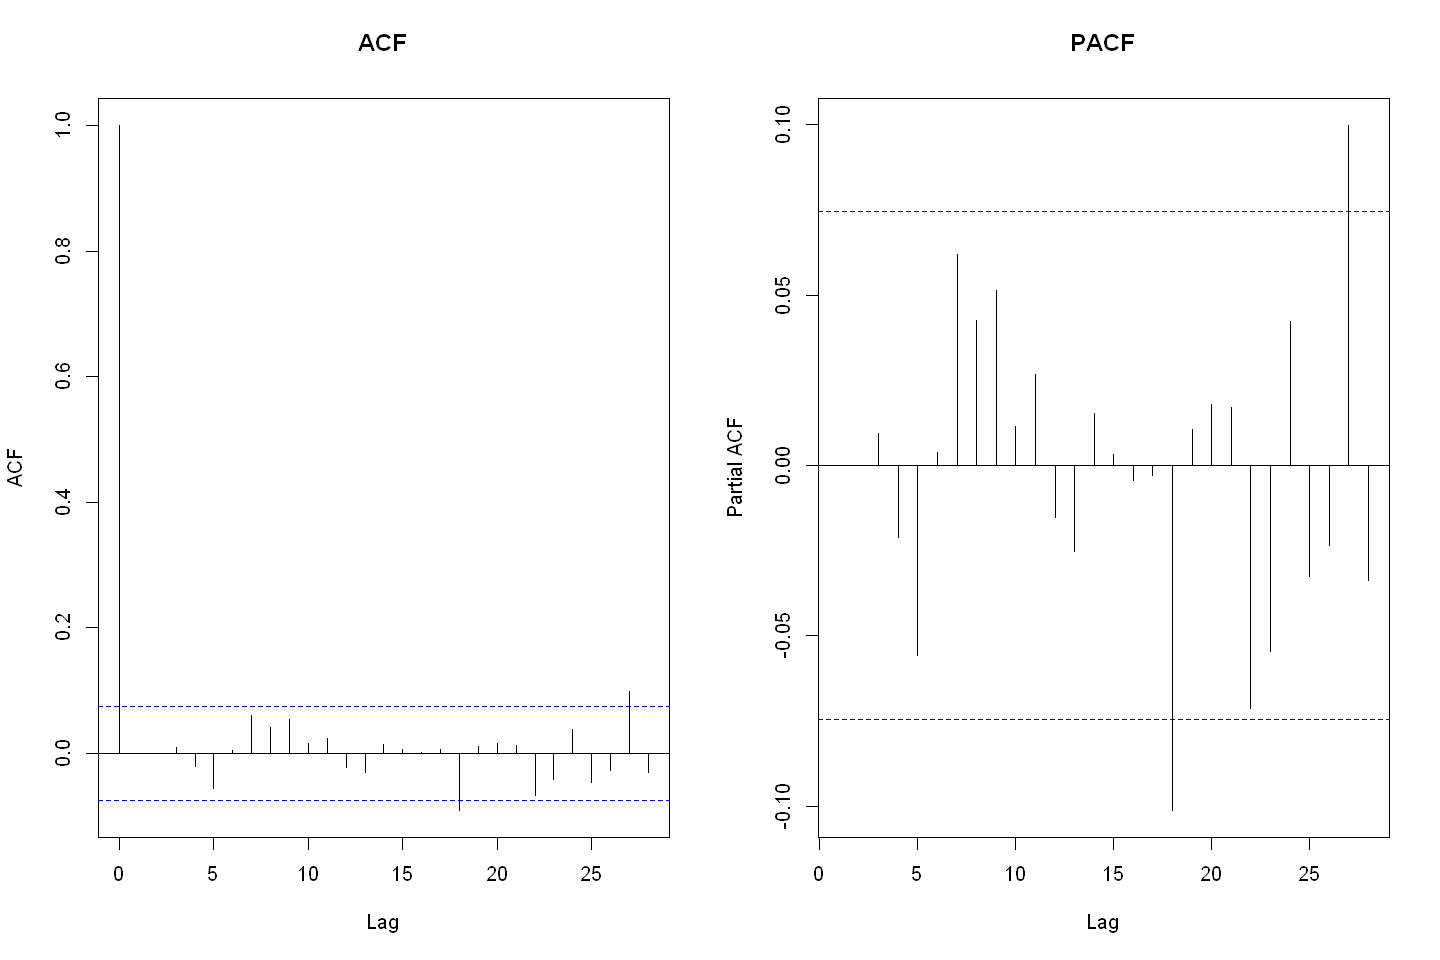

In [19]:
arma_33 <- Arima(daily_returns, order=c(3,0,3))
arma_33

par(mfrow = c(1, 2))
acf(arma_33$residuals, main = "ACF")
pacf(arma_33$residuals, main = "PACF")

Box.test(arma_33$residuals, type = "Ljung-Box", lag = 4)
Box.test(arma_33$residuals, type = "Ljung-Box", lag = 8)
Box.test(arma_33$residuals, type = "Ljung-Box", lag = 12)

#### f) ARMA(2,4)

Series: daily_returns 
ARIMA(2,0,4) with non-zero mean 

Coefficients:
          ar1      ar2     ma1     ma2     ma3     ma4   mean
      -1.6757  -0.8290  1.6305  0.8879  0.1698  0.0255  0e+00
s.e.   0.0563   0.0555  0.0671  0.0896  0.0771  0.0473  7e-04

sigma^2 = 0.0003193:  log likelihood = 1806.49
AIC=-3596.99   AICc=-3596.78   BIC=-3560.67


	Box-Ljung test

data:  arma_24$residuals
X-squared = 0.3939, df = 4, p-value = 0.983



	Box-Ljung test

data:  arma_24$residuals
X-squared = 6.4593, df = 8, p-value = 0.5959



	Box-Ljung test

data:  arma_24$residuals
X-squared = 9.4362, df = 12, p-value = 0.6653


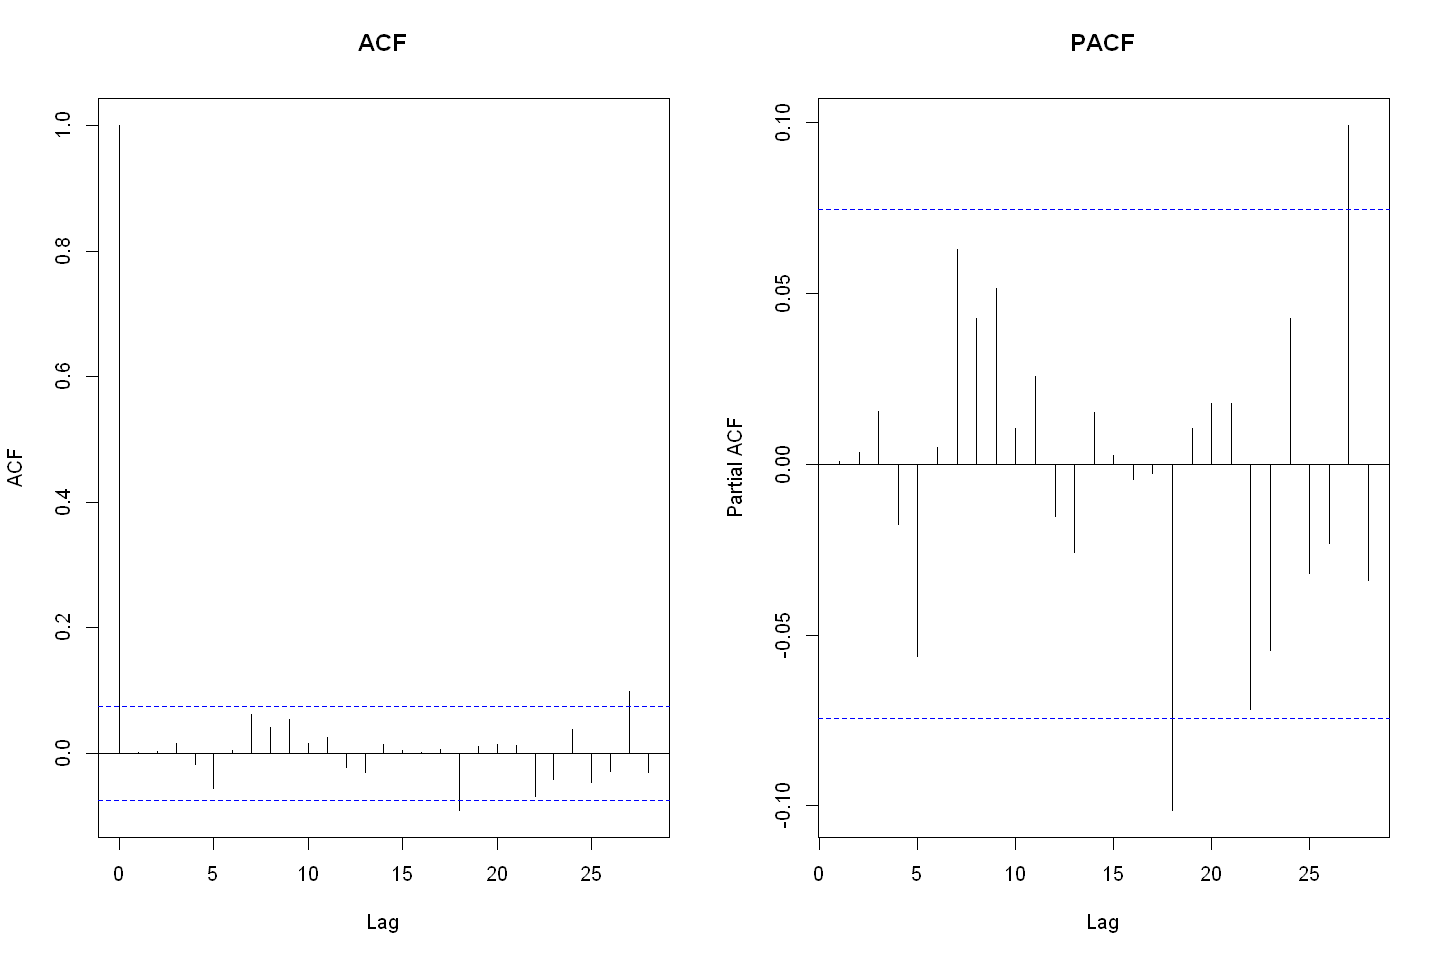

In [20]:
arma_24 <- Arima(daily_returns, order=c(2,0,4))
arma_24

par(mfrow = c(1, 2))
acf(arma_24$residuals, main = "ACF")
pacf(arma_24$residuals, main = "PACF")

Box.test(arma_24$residuals, type = "Ljung-Box", lag = 4)
Box.test(arma_24$residuals, type = "Ljung-Box", lag = 8)
Box.test(arma_24$residuals, type = "Ljung-Box", lag = 12)

The general idea of order selection was to keep our models as simple as possible since there is not enough added value from estimating higher orders given the cost of overfitting and power. Models with lower orders were, therefore, rejected by the Ljung-box test indicating they are not able to remove the dependencies well (We rejected the H0 hypothesis). Moreover, the ACF and PACF functions reveal these dependencies being out of the treshold borders as well. An example of "not suffitient" model is a) where we used the function automaticly selecting the order. This is also a nice example of being cautious with using the auto-function.

All of the remainign model are able to remove the dependencies well enough through AR, MR, or a combination of both (based on the Ljung-box tests not rejecting the H0 hypothesis). Even though some lags in ACF and PACF still exceed the boarders, they are not significant enough to distort our estimations. Therefore, we have succesfully extracted the information hidden in serial correlation and avoid statistical issues with modelling for all models b) - f).

The analyzysis proces we used was to estimate various combinations of AR and ME orders in the ARIMA function (prefering those we suspected from ACF and PACF) and always mainly checking the Ljung-box tests. If the p-values were above 0.05 treshold for all selected lags, a model is used further. We then cross-cheched this selection with the updated ACF and PACF if dependencies are removed. If p-values were below 0.05 for any lag, we proceeded with a more complicated model.

#### Information criteria 

In [120]:
models <- 6
criteria <- matrix(ncol=2, nrow=models)
colnames(criteria) <- c('AIC', 'BIC')
rownames(criteria) <- c('auto', 'AR(7)', 'MA(8)', 'ARMA(4,1)', 'ARMA(3,3)', 'ARMA(2,4)')

criteria[1,1] <- auto$aic
criteria[1,2] <- auto$bic
criteria[2,1] <- ar_7$aic
criteria[2,2] <- ar_7$bic
criteria[3,1] <- ma_8$aic
criteria[3,2] <- ma_8$bic
criteria[4,1] <- arma_41$aic
criteria[4,2] <- arma_41$bic
criteria[5,1] <- arma_33$aic
criteria[5,2] <- arma_33$bic
criteria[6,1] <- arma_24$aic
criteria[6,2] <- arma_24$bic

criteria

,AIC,BIC
auto,-3561.842,-3548.223
AR(7),-3595.142,-3554.286
MA(8),-3583.964,-3538.568
"ARMA(4,1)",-3593.881,-3562.104
"ARMA(3,3)",-3597.082,-3560.765
"ARMA(2,4)",-3596.920,-3560.604


Comparing the amounts of information delivered by our models AIC and BIC help us to choose the best candidate out of all eligible models. We decided to choose the ARMA(3,3) process as it minimizes AIC criteria and almost even BIC criteria.  

Finally, the suspicion of heteroskedasticity in our residuals from the first graph of Problem 2 comes into play. We performed the ARCH test to see if volatility changes across time.  

ARCH heteroscedasticity test for residuals 
alternative: heteroscedastic 

Portmanteau-Q test: 
     order  PQ p.value
[1,]     4 397       0
[2,]     8 608       0
[3,]    12 733       0
[4,]    16 751       0
[5,]    20 790       0
[6,]    24 804       0
Lagrange-Multiplier test: 
     order    LM  p.value
[1,]     4 286.3 0.00e+00
[2,]     8 129.5 0.00e+00
[3,]    12  78.1 3.39e-12
[4,]    16  52.6 4.54e-06
[5,]    20  38.5 5.14e-03
[6,]    24  30.9 1.24e-01


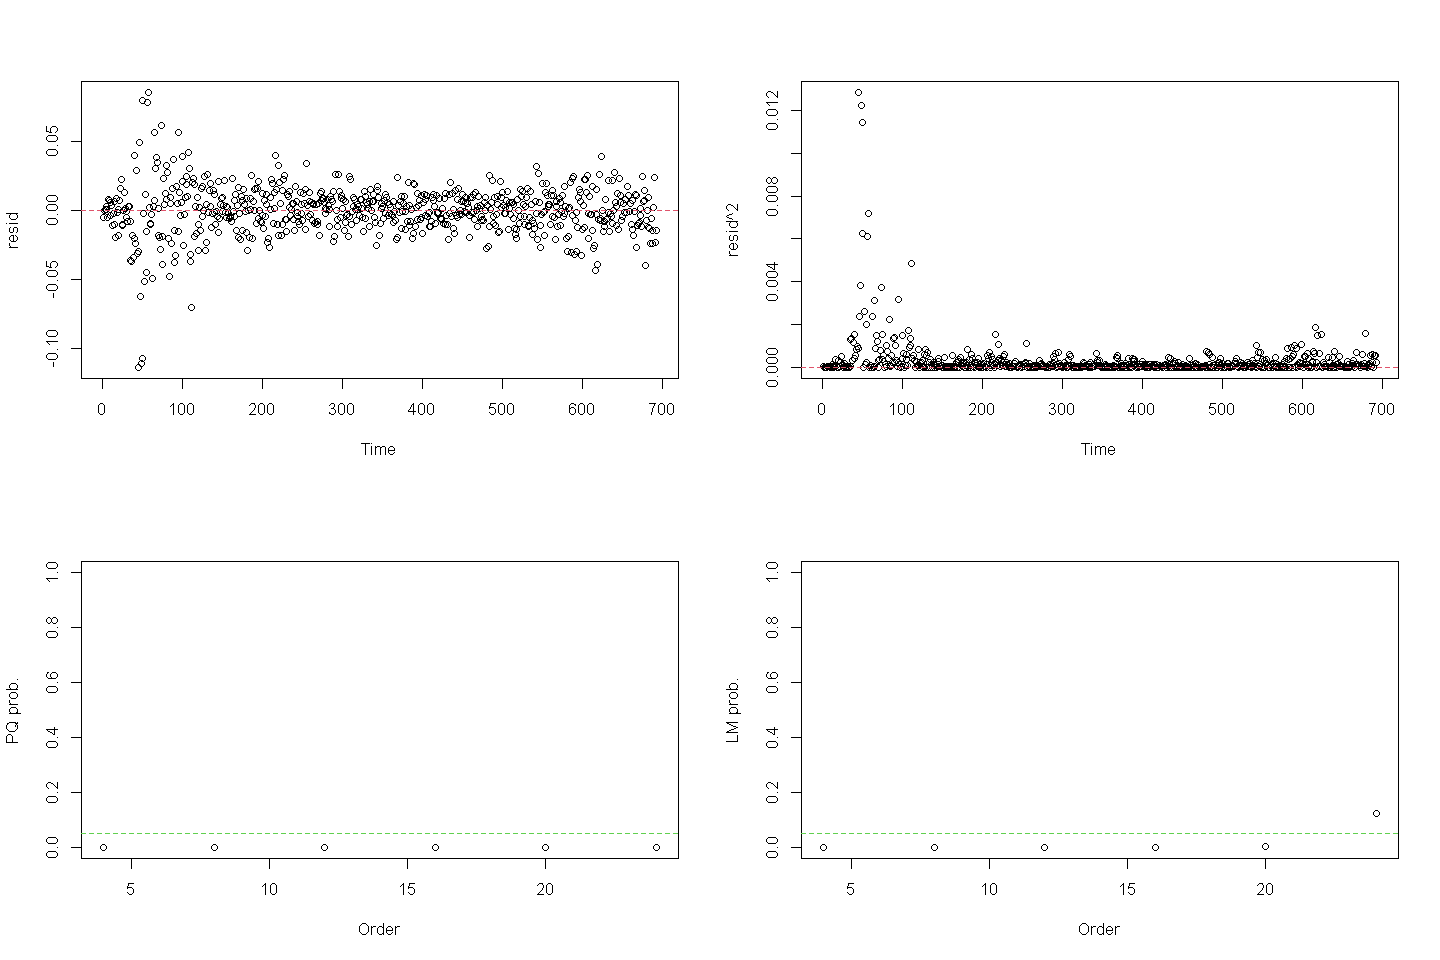

In [124]:
arma_best <- arima(daily_returns, order=c(3,0,3))
arch.test(arma_best)

We found a strong evidence of the volatility being different for various intervals. We would proceed with adding some form of GARCH model into our estimation to model volatility before making predictios. Moreover, we could try to divide our data after the Covid-19 high volatility period since it can distort the remaining time series as well. However, this suggestions are out of scope for this task. 